In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from collections import defaultdict
import statistics as stats
from collections import Counter
from scipy.stats import fisher_exact, yeojohnson
import numpy as np
import seaborn as sns
from scipy.stats import f_oneway, ttest_ind, pearsonr
from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression
import pickle
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Chromosomes by length

Source - https://www.ncbi.nlm.nih.gov/grc/human/data

In [2]:
! gsutil cp gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/chr_lengths.csv .

Copying gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/chr_lengths.csv...
/ [1 files][  318.0 B/  318.0 B]                                                
Operation completed over 1 objects/318.0 B.                                      


In [3]:
chr_length_df = pd.read_csv('chr_lengths.csv', header = None)

chr_length_dict = pd.Series(pd.to_numeric(chr_length_df[1].values),index=chr_length_df[0]).to_dict()

# Importing mocha for mCAs

In [4]:
! gsutil cp gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/long.mocha.filtered.csv .

Copying gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/long.mocha.filtered.csv...
/ [1 files][  1.2 MiB/  1.2 MiB]                                                
Operation completed over 1 objects/1.2 MiB.                                      


In [5]:
mocha_df = pd.read_csv("long.mocha.filtered.csv", sep = '\t')

In [6]:
mocha_df

,sample_id,computed_gender,chrom,beg_GRCh38,end_GRCh38,length,p_arm,q_arm,n_sites,n_hets,...,bdev_se,rel_cov,rel_cov_se,lod_lrr_baf,lod_baf_phase,n_flips,baf_conc,lod_baf_conc,type,cf
0,NWD100095,FALSE,chrX,76029422,156004717,79975295,N,T,23749,23749,...,0.0006,2.1476,0.0025,0.00,12.47,2,0.5031,0.12,Gain,0.0195
1,NWD100109,FALSE,chrX,0,156005065,156005065,T,T,29590,29590,...,0.0005,2.0804,0.0021,0.00,50.74,10,0.5104,2.30,Gain,0.0357
2,NWD100133,FALSE,chrX,0,156008488,156008488,T,T,31676,31676,...,0.0005,1.9159,0.0022,0.00,9.16,3,0.5014,0.01,Loss,0.0162
3,NWD100227,FALSE,chrX,0,156007047,156007047,T,T,45344,45344,...,0.0004,1.9563,0.0018,0.00,23.90,10,0.5027,0.09,Loss,0.0241
4,NWD100329,FALSE,chrX,0,156006895,156006895,T,T,37661,37661,...,0.0005,1.9472,0.0021,0.00,46.44,4,0.5008,0.03,Loss,0.0308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10110,NWD999511,FALSE,chr11,86216910,135076140,48859230,N,T,15370,15370,...,0.0012,2.0017,0.0032,1750.57,4327.75,45,0.8076,1307.77,CN-LOH,0.2211
10111,NWD999511,FALSE,chrX,0,155698490,155698490,T,T,30375,30375,...,0.0006,1.9430,0.0023,0.00,14.43,7,0.4982,0.26,Loss,0.0253
10112,NWD999572,FALSE,chrX,0,156000685,156000685,T,T,28225,28225,...,0.0006,1.9670,0.0024,0.00,24.93,5,0.5046,0.24,Loss,0.0275
10113,NWD999849,FALSE,chrX,0,155999869,155999869,T,T,27039,27039,...,0.0005,2.0557,0.0023,0.00,80.56,13,0.5124,2.38,Gain,0.0486


In [7]:
#Add necessary columns to mocha_df
mocha_df['q_arm_bool'] = False
mocha_df.loc[(mocha_df['q_arm'] == 'T'),'q_arm_bool'] = True
mocha_df.loc[(mocha_df['q_arm'] == 'Y'),'q_arm_bool'] = True
mocha_df.loc[(mocha_df['q_arm'] == 'TRUE'),'q_arm_bool'] = True
mocha_df['p_arm_bool'] = False
mocha_df.loc[(mocha_df['p_arm'] == 'T'),'p_arm_bool'] = True
mocha_df.loc[(mocha_df['p_arm'] == 'Y'),'p_arm_bool'] = True
mocha_df.loc[(mocha_df['p_arm'] == 'TRUE'),'p_arm_bool'] = True
mocha_df['botharms_bool'] = False
mocha_df.loc[(mocha_df['p_arm_bool']==True) & (mocha_df['q_arm_bool']==True), 'botharms_bool'] = True
mocha_df['arm_short'] = ''
mocha_df.loc[((mocha_df['p_arm_bool']) == True & (mocha_df['q_arm_bool']==False)),'arm_short'] = 'p'
mocha_df.loc[((mocha_df['p_arm_bool']) == False & (mocha_df['q_arm_bool']==True)),'arm_short'] = 'q'
mocha_df.loc[(mocha_df['botharms_bool'] == True),'arm_short'] = ''

mocha_df['type_short'] = "U"
mocha_df.loc[mocha_df['type'] == 'Gain', 'type_short'] = "+"
mocha_df.loc[mocha_df['type'] == 'Loss', 'type_short'] = "-"
mocha_df.loc[mocha_df['type'] == 'CN-LOH', 'type_short'] = "="

mocha_df['mca'] = mocha_df['type'] + " in " + mocha_df['chrom']
mocha_df['chrom_short'] = mocha_df['chrom'].str.replace("chr","")
mocha_df['mca_short'] = mocha_df['chrom_short'] + mocha_df['type_short']
mocha_df['mca_short_arm'] = mocha_df['chrom_short'] + mocha_df['arm_short'] + mocha_df['type_short']

mocha_df_nochrx = mocha_df[mocha_df['chrom'] != 'chrX']
mocha_df_nochrx['chrom_short'] = pd.to_numeric(mocha_df_nochrx['chrom_short'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [8]:
def clean_mca(df):
    mocha_dict_by_id = defaultdict(set)
    mocha_dict_by_id_short = defaultdict(set)
    mocha_dict_by_id_arm_short = defaultdict(set)
    mocha_cf_dict = dict()

    for index, row in df.iterrows():
        mca = str(row['type'] + " in " + row['chrom'])
        mocha_dict_by_id[row['sample_id']].add(mca)
        mocha_dict_by_id_short[row['sample_id']].add(row['mca_short'])
        mocha_dict_by_id_arm_short[row['sample_id']].add(row['mca_short_arm'])
        mocha_cf_dict[row['sample_id']] = row['cf']
    
    more_than_one_mca = 0
    keys = []
    mcas = []
    mcas_short = []
    cfs = []
    mcas_short_arm = []
    single_mca_enrichment = []
    mult_mca_enrichment = []
    for key, value in mocha_dict_by_id.items():
        if len(value) < 2:
            single_mca_enrichment.append(list(value)[0])
            keys.append(key)
            mcas.append(', '.join(value))
            mcas_short.append(','.join(mocha_dict_by_id_short[key]))
            cfs.append(mocha_cf_dict[key])
            mcas_short_arm.append(', '. join(mocha_dict_by_id_arm_short[key]))
        else: 
            more_than_one_mca = more_than_one_mca+1
            mult_mca_enrichment.extend(value)


    mca_string_df = pd.DataFrame(zip(keys,mcas,mcas_short,cfs, mcas_short_arm), 
                                 columns = ['sample.id', 'mCAs','mCA', 'cf', 'mCA w arm'])
    
    print(str(more_than_one_mca) + " pts had > 1 mCA and were thus excluded")
    return mca_string_df

In [9]:
mocha_clean_df = clean_mca(mocha_df)
mocha_clean_nochrx_df = clean_mca(mocha_df_nochrx)

763 pts had > 1 mCA and were thus excluded
376 pts had > 1 mCA and were thus excluded


In [10]:
mca_chr_dict = pd.Series(mocha_clean_nochrx_df['mCA'].values,index=mocha_clean_nochrx_df['sample.id']).to_dict()

# Importing updated topmed data for passenger mutations 

In [11]:
!gsutil cp gs://fc-b7cd8c47-767b-4eda-b456-736a92f723ac/data/singletons_spark_2021_05_25.parquet .

Copying gs://fc-b7cd8c47-767b-4eda-b456-736a92f723ac/data/singletons_spark_2021_05_25.parquet...
- [1 files][615.1 MiB/615.1 MiB]   40.0 MiB/s                                   
Operation completed over 1 objects/615.1 MiB.                                    


In [12]:
topmed_df = pd.read_parquet('singletons_spark_2021_05_25.parquet')
topmed_ct_df = topmed_df[((topmed_df.REF == "C") & (topmed_df.ALT == "T")) | ((topmed_df.REF == "T") & (topmed_df.ALT == "C"))]

## Get passenger mutations by chr for pts with 1 mCA

In [13]:
def get_pass_mut_by_chr(pass_df, mca_df):
    pass_mut_dict = {}
    for nwdid in list(mca_df['sample.id'].unique()):
        pass_mut_dict[nwdid] = defaultdict(int)
        for chrom in range(1, 23):
            pass_mut_dict[nwdid][chrom] = 0
    print('Made dictionary')
    pass_mca_df = pass_df[pass_df['NWD_ID'].isin(list(mca_df['sample.id'].unique()))]
    for index, row in pass_mca_df.iterrows():
        if row['CHROM'] != 23: 
            pass_mut_dict[row['NWD_ID']][row['CHROM']] += 1
#     for nwdid in list(mca_df['sample.id'].unique()):
#         chr_group_df = pd.DataFrame(pass_df[pass_df['NWD_ID'] == nwdid].groupby('CHROM').describe())
#         if len(chr_group_df) > 1:
#             chrom_count_df = pd.DataFrame(chr_group_df['POS']['count'])
#         pass_mut_dict[nwdid] = pd.Series(chrom_count_df['count'].values,index=chrom_count_df.index).to_dict()
    return pass_mut_dict

In [14]:
pass_mut_dict_bychr_mca = get_pass_mut_by_chr(topmed_ct_df, mocha_clean_nochrx_df)

Made dictionary


## Calculate passenger mutations on mCA chromosomes vs not

In [15]:
mca_or_nonmca_status = []
mcas = []
passengers = []
passengers_per_bp = []
for nwdid in list(mocha_clean_nochrx_df['sample.id'].unique()):
    mca = mca_chr_dict[nwdid]
    mca_chr = (mca_chr_dict[nwdid])[:-1]
    for key, value in pass_mut_dict_bychr_mca[nwdid].items():
        if str(key) == str(mca_chr):
            mcas.append(mca)
            mca_or_nonmca_status.append('Yes')
            passengers_per_bp.append(value/chr_length_dict[str(key)]  * 1e6)
            passengers.append(value)
        else:
            mcas.append(mca)
            mca_or_nonmca_status.append('No')
            passengers_per_bp.append(value/chr_length_dict[str(key)] * 1e6)
            passengers.append(value)

In [16]:
pass_by_mcachr = pd.DataFrame(zip(mca_or_nonmca_status, passengers, passengers_per_bp, mcas), 
                              columns=['on mCA chromosome', "Number of passenger mutations", "Passenger mutations per $10^{6}$ bp", "mCAs"])

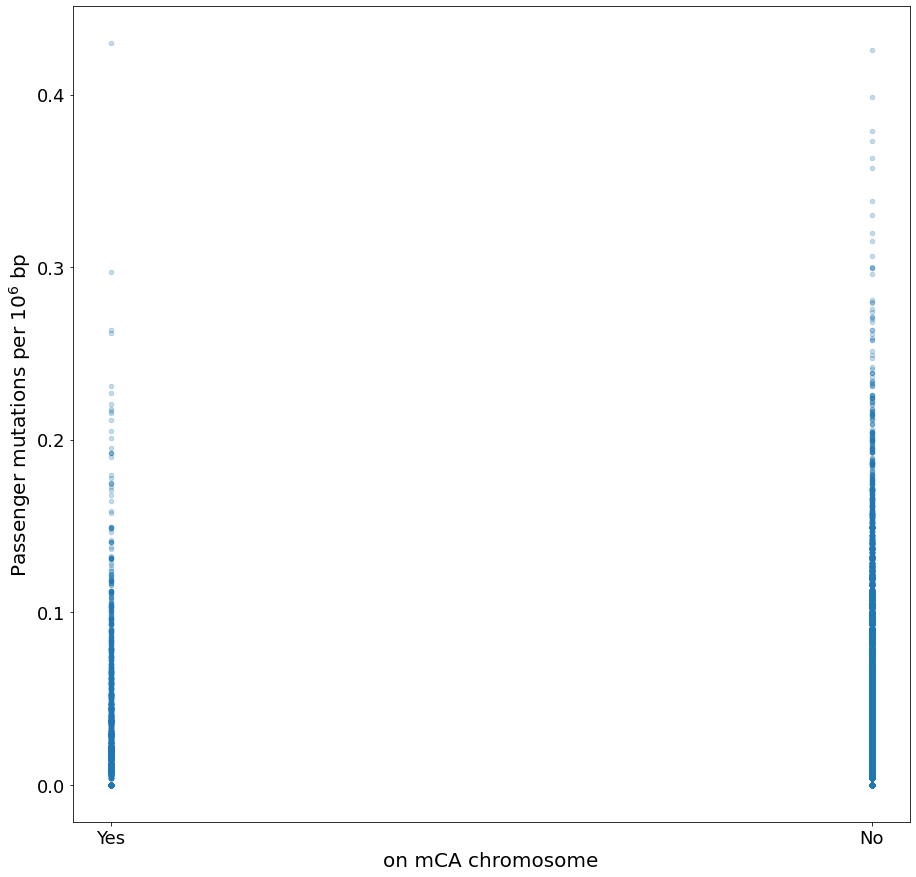

In [17]:
pass_by_mcachr.plot.scatter(x = "on mCA chromosome", y = "Passenger mutations per $10^{6}$ bp", 
                            alpha=0.25, fontsize = 18, figsize=(15,15))
plt.xlabel("on mCA chromosome", fontsize = 20)
plt.ylabel("Passenger mutations per $10^{6}$ bp", fontsize = 20)
plt.show()

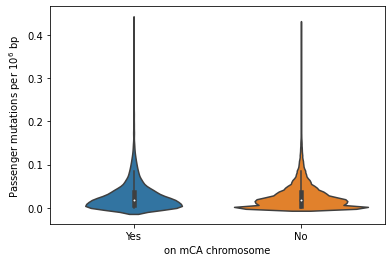

Number of passenger mutations                                \
                                          count      mean       std  min  25%   
on mCA chromosome                                                               
No                                      56532.0  3.584713  4.682008  0.0  1.0   
Yes                                      2692.0  3.859955  5.161898  0.0  1.0   

                                  Passenger mutations per $10^{6}$ bp  \
                   50%  75%   max                               count   
on mCA chromosome                                                       
No                 2.0  5.0  82.0                             56532.0   
Yes                2.0  5.0  78.0                              2692.0   

                                                                          \
                       mean       std  min       25%       50%       75%   
on mCA chromosome                                                          
No                 0.026468  0.030250  0.0  0.005043  0.018684  0.037326   
Yes                0.028407  0.034411  0.0  0.005508  0.018827  0.037654   

                             
                        max  
on mCA chromosome            
No                 0.425835  
Yes                0.429661

In [18]:
sns.violinplot(x = "on mCA chromosome", y = "Passenger mutations per $10^{6}$ bp",
                data=pass_by_mcachr)
plt.show()
pass_by_mcachr.groupby('on mCA chromosome').describe()

# Compare tot pass mut count with and without mCA chrom

In [19]:
tot_pass_mut = defaultdict(int)
tot_pass_mut_wo_mca = defaultdict(int)
for nwdid in list(mocha_clean_nochrx_df['sample.id'].unique()):
    mca_chr = (mca_chr_dict[nwdid])[:-1]
    for key, value in pass_mut_dict_bychr_mca[nwdid].items():
        if str(key) != str(mca_chr):
            tot_pass_mut_wo_mca[nwdid] += value
        tot_pass_mut[nwdid] += value
        
nwdids = []
tot_pass_mut_list = []
tot_pass_mut_wo_mca_list = []
for key, value in tot_pass_mut.items():
    nwdids.append(key)
    tot_pass_mut_list.append(value)
    tot_pass_mut_wo_mca_list.append(tot_pass_mut_wo_mca[key])
    
pass_mut_mca_df = pd.DataFrame(zip(nwdids, tot_pass_mut_list,tot_pass_mut_wo_mca_list), 
             columns = ['nwdids', 'tot_pass_mut_list', 'tot_pass_mut_wo_mca_list'])
pass_mut_mca_df['diff'] = pass_mut_mca_df['tot_pass_mut_list'] - pass_mut_mca_df['tot_pass_mut_wo_mca_list']
pass_mut_mca_df['mca'] = pass_mut_mca_df['nwdids'].map(mca_chr_dict)
pass_mut_mca_df['chr'] = pass_mut_mca_df['mca'].str[:-1]
pass_mut_mca_df['chr'] = pd.to_numeric(pass_mut_mca_df['chr'])
pass_mut_mca_df['type'] = pass_mut_mca_df['mca'].str[-1]
pass_mut_mca_df = pass_mut_mca_df[pass_mut_mca_df['type']!='U']

In [20]:
diff_perlength = []
for index, row in pass_mut_mca_df.iterrows():
    diff_perlength.append(row['diff']/chr_length_dict[row['mca'][:-1]])
    
pass_mut_mca_df['diff_perlength'] = diff_perlength

In [21]:
mca_bychr_passmut = pd.DataFrame(pass_by_mcachr.groupby(['mCAs', 'on mCA chromosome']).describe()['Passenger mutations per $10^{6}$ bp'])

In [22]:
mca_bychr_passmut = mca_bychr_passmut.reset_index(level=0)
mca_bychr_passmut = mca_bychr_passmut.reset_index(level=0)

In [23]:
mca_bychr_passmut['chr'] = mca_bychr_passmut['mCAs'].str[:-1]
mca_bychr_passmut['chr'] = pd.to_numeric(mca_bychr_passmut['chr'])
mca_bychr_passmut['type'] = mca_bychr_passmut['mCAs'].str[-1]
mca_bychr_passmut.sort_values(['chr', 'type'], inplace=True)
mca_bychr_passmut['iqr'] = mca_bychr_passmut['75%']-mca_bychr_passmut['25%']
mca_bychr_passmut = mca_bychr_passmut[mca_bychr_passmut['type'] != 'U']

In [24]:
mca_bychr_passmut_nochr = mca_bychr_passmut[mca_bychr_passmut['on mCA chromosome']=="No"]
mca_bychr_passmut_yeschr = mca_bychr_passmut[mca_bychr_passmut['on mCA chromosome']=="Yes"]

In [25]:
pass_mut_density = pd.DataFrame(zip(mca_bychr_passmut_yeschr['mCAs'], 
                                    mca_bychr_passmut_yeschr['50%'], mca_bychr_passmut_nochr['50%']),
                                columns = ['mCAs', 'mCA chromosome', 'non-mCA chromosomes'])
pass_mut_density['diff'] = pass_mut_density['mCA chromosome'] - pass_mut_density['non-mCA chromosomes']
pass_mut_density.sort_values('diff', inplace = True, ascending = False)

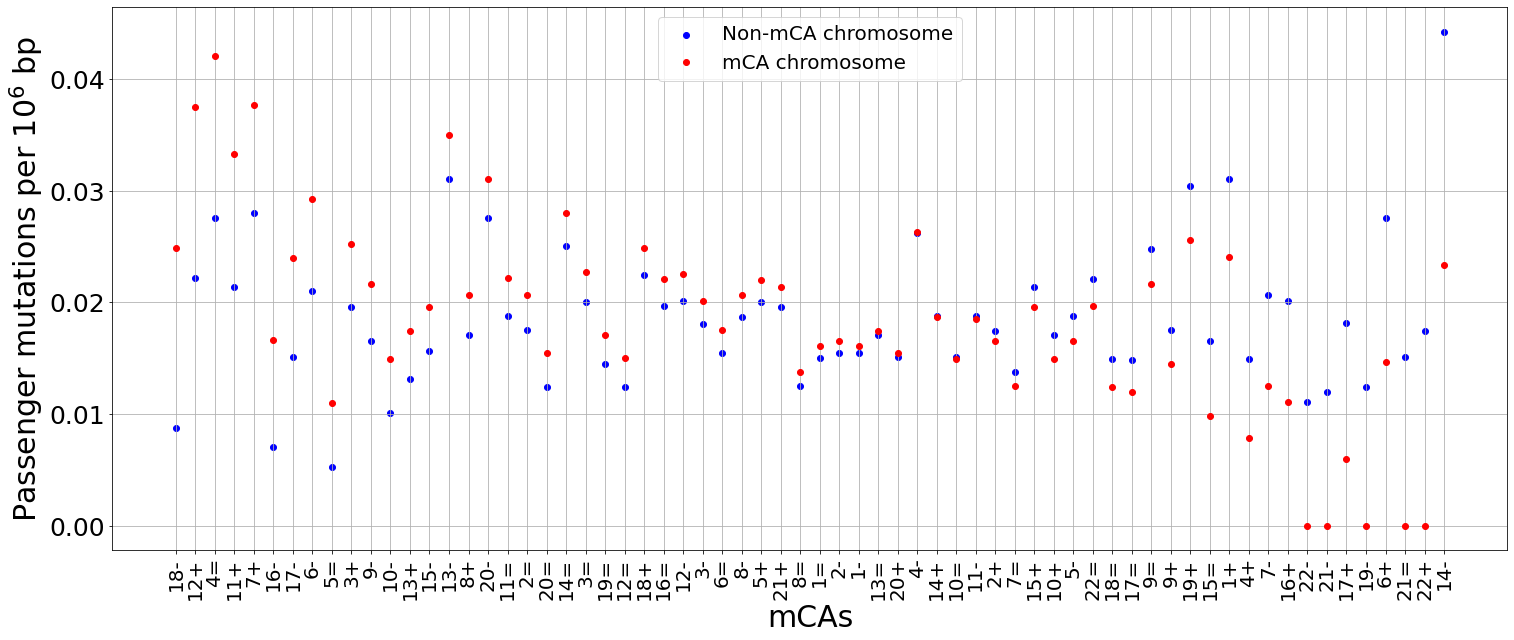

In [31]:
plt.figure(figsize=(25,10))
plt.scatter(x=pass_mut_density['mCAs'], y=pass_mut_density['non-mCA chromosomes'] ,
                marker='o', color = 'blue', label='Non-mCA chromosome')

plt.errorbar(x=pass_mut_density['mCAs'], y=pass_mut_density['mCA chromosome'],
                marker='o', ls='', color = 'red', label='mCA chromosome')
plt.legend(fontsize=20, loc='upper center')
plt.tick_params(axis='y', which='major', labelsize=25)
plt.tick_params(axis='x', which='major', labelsize=20, rotation = 90)
plt.xlabel('mCAs', fontsize = 30)
plt.ylabel('Passenger mutations per $10^{6}$ bp', fontsize=30)
plt.grid()
plt.savefig('supfig1a_passmutdensity.tif')
plt.show()

In [32]:
! gsutil cp supfig1a_passmutdensity.tif gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/figures/supfig1a_passmutdensity.tif

Copying file://supfig1a_passmutdensity.tif [Content-Type=image/tiff]...
/ [1 files][  4.9 MiB/  4.9 MiB]                                                
Operation completed over 1 objects/4.9 MiB.                                      


# See if number of passenger mutations per bp on an mCA chromosome correlates with PACER score

In [33]:
mca_bychr_passmut_yeschr.rename(columns={"mCAs": "mCA"}, inplace=True)
mca_bychr_passmut_nochr.rename(columns={"mCAs": "mCA"}, inplace = True)
mca_bychr_passmut_yeschr = mca_bychr_passmut_yeschr.set_index('mCA')
mca_bychr_passmut_nochr = mca_bychr_passmut_nochr.set_index('mCA') 

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [34]:
difference = mca_bychr_passmut_yeschr['50%'] - mca_bychr_passmut_nochr['50%']

In [35]:
! gsutil cp gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/PACER_fitness_bymca.csv .

Copying gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/PACER_fitness_bymca.csv...
/ [1 files][  6.5 KiB/  6.5 KiB]                                                
Operation completed over 1 objects/6.5 KiB.                                      


In [36]:
fitness_by_mca = pd.read_csv('PACER_fitness_bymca.csv').drop(0)
fitness_by_mca = fitness_by_mca.set_index('mCA')

In [37]:
diff = pd.DataFrame(difference)

In [62]:
diff_fitness = fitness_by_mca.merge(diff, left_index = True, right_index=True)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<Figure size 1440x1440 with 0 Axes>

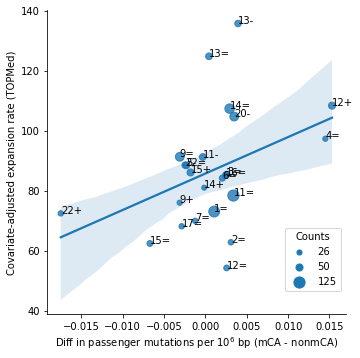

In [65]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], str(point['val']), size=10)

plt.figure(figsize=(20,20))
diff_fitness = diff_fitness.reset_index(0)
g = sns.lmplot('50%','tpm', data=diff_fitness, scatter_kws={"s": diff_fitness['count']})
# g.map_dataframe(annotate)
marker1 = plt.scatter([],[], s=diff_fitness['count'].min(), c='C0')
marker2 = plt.scatter([],[], s=diff_fitness['count'].mean(), c='C0')
marker3 = plt.scatter([],[], s=diff_fitness['count'].max(), c='C0')
legend_markers = [marker1, marker2, marker3]

labels = [
    str(round(diff_fitness['count'].min())),
    str(round(diff_fitness['count'].mean())),
    str(round(diff_fitness['count'].max()))
    ]

legend= plt.legend(handles=legend_markers, labels=labels, title='Counts',
                    frameon=True, bbox_to_anchor=(1, 0.3))

plt.ylabel("Covariate-adjusted expansion rate (TOPMed)")
plt.xlabel("Diff in passenger mutations per $10^{6}$ bp (mCA - nonmCA)")
label_point(diff_fitness['50%'], diff_fitness['tpm'], diff_fitness['mCA'], plt.gca())  
plt.savefig('supfig1b_corrbtwnmcaandnot.tif', dpi = 300)
plt.show()

In [66]:
! gsutil cp supfig1b_corrbtwnmcaandnot.tif gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/figures/supfig1b_corrbtwnmcaandnot.tif

Copying file://supfig1b_corrbtwnmcaandnot.tif [Content-Type=image/tiff]...
/ [1 files][  8.6 MiB/  8.6 MiB]                                                
Operation completed over 1 objects/8.6 MiB.                                      


In [41]:
diff_fitness['median']= diff_fitness['50%']
model = smf.glm('median~tpm', data=diff_fitness)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 median   No. Observations:                   24
Model:                            GLM   Df Residuals:                       22
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                      3.4970e-05
Method:                          IRLS   Log-Likelihood:                 90.122
Date:                Fri, 19 Aug 2022   Deviance:                   0.00076934
Time:                        17:17:26   Pearson chi2:                 0.000769
No. Iterations:                     3   Pseudo R-squ. (CS):             0.1576
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0103      0.006     -1.840      0.066      -0.021       0.001
tpm            0.0001   6.35e-05      2.007      0.045    2.97e-06       0.000
==============================================================================
"""